In [9]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.optim.optimizer import Optimizer, required
from matplotlib import pyplot as plt
import numpy as np
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [4]:
batch_size = 100
n_iters = 3000
epochs = n_iters / (len(train_dataset) / batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.001

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class SVRG(Optimizer):
    r""" implement SVRG """ 

    def __init__(self, params, lr=required, freq =10):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, freq=freq)
        self.counter = 0
        self.counter2 = 0
        self.flag = False
        super(SVRG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SVRG, self).__setstate__(state)
        # for group in self.param_groups:
        #     group.setdefault('m', )

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            freq = group['freq']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                param_state = self.state[p]
                
                if 'large_batch' not in param_state:
                    buf = param_state['large_batch'] = torch.zeros_like(p.data)
                    buf.add_(d_p) #add first large, low variance batch
                    #need to add the second term in the step equation; the gradient for the original step!
                    buf2 = param_state['small_batch'] = torch.zeros_like(p.data)

                buf = param_state['large_batch']
                buf2 = param_state['small_batch']

                if self.counter == freq:
                    buf.data = d_p.clone() #copy new large batch. Begining of new inner loop
                    temp = torch.zeros_like(p.data)
                    buf2.data = temp.clone()
                    
                if self.counter2 == 1:
                    buf2.data.add_(d_p) #first small batch gradient for inner loop!

                #dont update parameters when computing large batch (low variance gradients)
                if self.counter != freq and self.flag != False:
                    p.data.add_(-group['lr'], (d_p - buf2 + buf) )

        self.flag = True #rough way of not updating the weights the FIRST time we calculate the large batch gradient
        
        if self.counter == freq:
            self.counter = 0
            self.counter2 = 0

        self.counter += 1    
        self.counter2 += 1

        return loss

In [11]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [13]:
model = LogisticRegression(input_dim, output_dim)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = SVRG(model.parameters(), lr=lr_rate)

In [14]:
iter = 0
record=[]
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if iter%50==0:
            record.append(loss.item())
        iter+=1
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.876917839050293. Accuracy: 64.
Iteration: 1000. Loss: 1.560046672821045. Accuracy: 75.
Iteration: 1500. Loss: 1.4023611545562744. Accuracy: 78.
Iteration: 2000. Loss: 1.3344879150390625. Accuracy: 80.
Iteration: 2500. Loss: 1.1972334384918213. Accuracy: 81.
Iteration: 3000. Loss: 1.0787482261657715. Accuracy: 82.


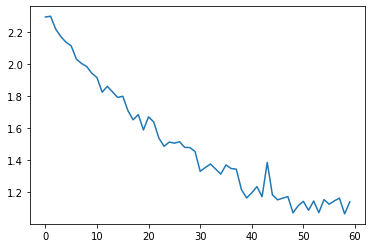

In [15]:
plt.plot(np.array(record))